# Forecasting Multiple Time Series

#### Loading Libraries

In [1]:
# Numerical Computing
import numpy as np
# Data Manipulation
import pandas as pd
# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Statistical Modeling
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
# Statistical Modeling API
import statsmodels.api as sm

# Iterators Optimizer
from tqdm.notebook import tqdm
from itertools import product
from typing import Union

# Warnings
import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline

#### Loading Data - US Macro Data

In [4]:
macro_econ_data = sm.datasets.macrodata.load_pandas().data
macro_econ_data

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
199,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
200,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
201,2009.0,2.0,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19


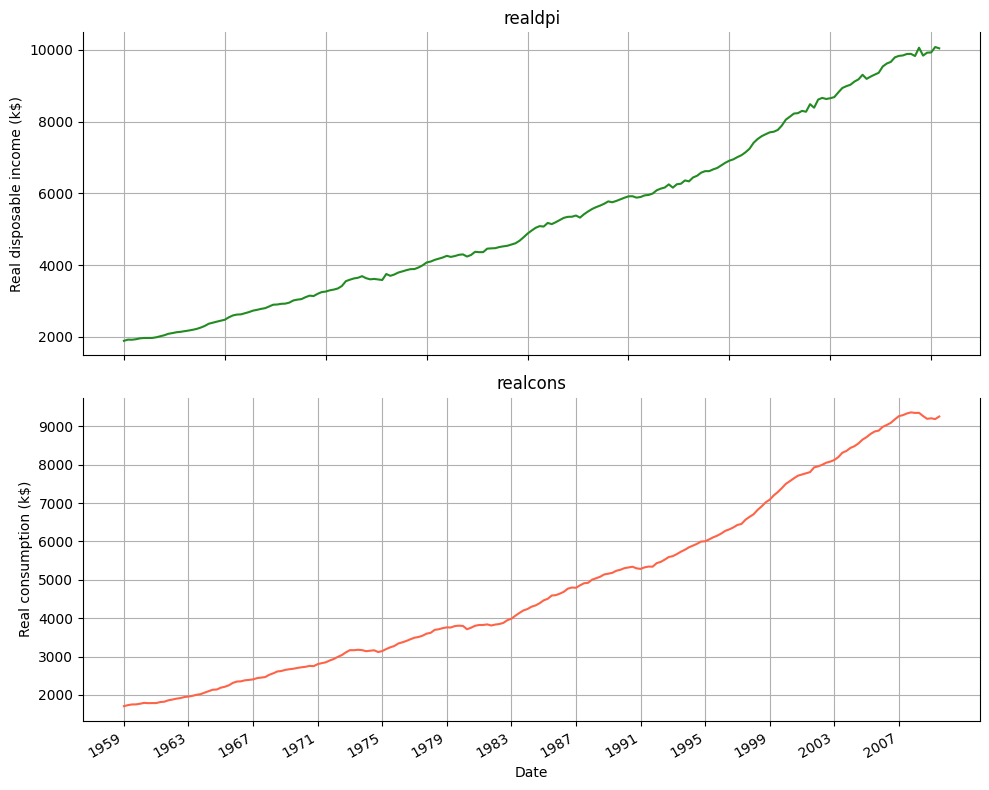

In [5]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,8))

ax1.plot(macro_econ_data['realdpi'], color='forestgreen')
ax1.set_xlabel('Date')
ax1.set_ylabel('Real disposable income (k$)')
ax1.set_title('realdpi')
ax1.spines['top'].set_alpha(0)
ax1.grid(True)

ax2.plot(macro_econ_data['realcons'], color='tomato')
ax2.set_xlabel('Date')
ax2.set_ylabel('Real consumption (k$)')
ax2.set_title('realcons')
ax2.spines['top'].set_alpha(0)
ax2.grid(True)

plt.xticks(np.arange(0, 208, 16), np.arange(1959, 2010, 4))

fig.autofmt_xdate()
plt.tight_layout()

#### Vector Autoregressive Model Procedure

#### Dickey-Fuller (ADF) Test

In [7]:
ad_fuller_result_1 = adfuller(macro_econ_data['realdpi'])

print('realdpi')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

ad_fuller_result_2 = adfuller(macro_econ_data['realcons'])

print('realcons')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

realdpi
ADF Statistic: 2.9860253519546864
p-value: 1.0

---------------------

realcons
ADF Statistic: 1.5499123380509636
p-value: 0.9976992503412904


##### Applying Differencing Procedure

In [9]:
# 1st Order Differencing on 'realdpi'
ad_fuller_result_1 = adfuller(macro_econ_data['realdpi'].diff()[1:])

print('realdpi')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

# 1st Order Differencing on 'realcons'
ad_fuller_result_2 = adfuller(macro_econ_data['realcons'].diff()[1:])

print('realcons')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

realdpi
ADF Statistic: -8.864893340673008
p-value: 1.4493606159108096e-14

---------------------

realcons
ADF Statistic: -4.204306080845247
p-value: 0.0006479282158627571


##### Setting VAR(p) Function

In [10]:
def optimize_VAR(endog: Union[pd.Series, list]) -> pd.DataFrame:
    
    results = []
    
    for i in tqdm(range(15)):
        try:
            model = VARMAX(endog, order=(i, 0)).fit(dips=False)
        except:
            continue
            
        aic = model.aic
        results.append([i, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['p', 'AIC']
    
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [11]:
# Endogenous Selection
endog = macro_econ_data[['realdpi', 'realcons']]

# Differenciated Endogenous Selection
endog_diff = macro_econ_data[['realdpi', 'realcons']].diff()[1:]

# Train Set
train = endog_diff[:162]
# Test Set
test = endog_diff[162:]

result_df = optimize_VAR(train)
result_df

  0%|          | 0/15 [00:00<?, ?it/s]

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.61849D+00    |proj g|=  2.88206D-03

At iterate    5    f=  9.61847D+00    |proj g|=  2.89230D-03

At iterate   10    f=  9.61834D+00    |proj g|=  3.17855D-03

At iterate   15    f=  9.61833D+00    |proj g|=  2.08507D-03

At iterate   20    f=  9.61831D+00    |proj g|=  7.03849D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     21     25      1     0     0   7.094D-05   9.618D+00
  F =   9.6183127883584909     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  9.53435D+00    |proj g|=  6.18732D-04

At iterate   20    f=  9.53427D+00    |proj g|=  6.00970D-03

At iterate   25    f=  9.53419D+00    |proj g|=  2.10891D-04

At iterate   30    f=  9.53418D+00    |proj g|=  6.56786D-04

At iterate   35    f=  9.53417D+00    |proj g|=  2.57567D-04

At iterate   40    f=  9.53417D+00    |proj g|=  6.87459D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     41     47      1     0     0   6.622D-05   9.534D+00
  F =   9.5341669202555437     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  9.53073D+00    |proj g|=  3.37638D-03

At iterate   10    f=  9.52882D+00    |proj g|=  5.77364D-03

At iterate   15    f=  9.52872D+00    |proj g|=  1.19735D-03

At iterate   20    f=  9.52848D+00    |proj g|=  6.53553D-03

At iterate   25    f=  9.52841D+00    |proj g|=  3.15848D-04

At iterate   30    f=  9.52840D+00    |proj g|=  2.43444D-04

At iterate   35    f=  9.52839D+00    |proj g|=  1.11681D-03

At iterate   40    f=  9.52838D+00    |proj g|=  4.83039D-04

At iterate   45    f=  9.52838D+00    |proj g|=  8.72276D-05

At iterate   50    f=  9.52838D+00    |proj g|=  2.29429D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  9.48825D+00    |proj g|=  2.28029D-02

At iterate   15    f=  9.48729D+00    |proj g|=  1.02704D-03

At iterate   20    f=  9.48716D+00    |proj g|=  6.60098D-03

At iterate   25    f=  9.48680D+00    |proj g|=  6.00227D-04

At iterate   30    f=  9.48679D+00    |proj g|=  7.33675D-04

At iterate   35    f=  9.48679D+00    |proj g|=  8.50793D-04

At iterate   40    f=  9.48676D+00    |proj g|=  1.74340D-03

At iterate   45    f=  9.48675D+00    |proj g|=  1.30305D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   25     45     52      1     0     0   1.303D-04   9.487D+00
  F =   9.48675470125

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           29     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.47781D+00    |proj g|=  3.35701D-02

At iterate    5    f=  9.47727D+00    |proj g|=  4.35159D-03

At iterate   10    f=  9.47491D+00    |proj g|=  2.97491D-02

At iterate   15    f=  9.47252D+00    |proj g|=  1.25347D-03

At iterate   20    f=  9.47249D+00    |proj g|=  2.06329D-03

At iterate   25    f=  9.47196D+00    |proj g|=  8.01756D-03

At iterate   30    f=  9.47183D+00    |proj g|=  4.76205D-04

At iterate   35    f=  9.47182D+00    |proj g|=  1.12303D-03

At iterate   40    f=  9.47181D+00    |proj g|=  1.76970D-03

At iterate   45    f=  9.47179D+00    |proj g|=  1.35988D-03

At iterate   50    f=  9.47178D+00    |proj g|=  8.86847D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           33     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.47542D+00    |proj g|=  3.72657D-02

At iterate    5    f=  9.47478D+00    |proj g|=  5.08595D-03

At iterate   10    f=  9.47087D+00    |proj g|=  2.26393D-02

At iterate   15    f=  9.46827D+00    |proj g|=  1.86586D-03

At iterate   20    f=  9.46823D+00    |proj g|=  1.91934D-03

At iterate   25    f=  9.46766D+00    |proj g|=  1.74552D-02

At iterate   30    f=  9.46737D+00    |proj g|=  1.13693D-03

At iterate   35    f=  9.46733D+00    |proj g|=  2.55538D-03

At iterate   40    f=  9.46732D+00    |proj g|=  4.79972D-04

At iterate   45    f=  9.46729D+00    |proj g|=  3.18209D-03

At iterate   50    f=  9.46728D+00    |proj g|=  8.48526D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           37     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.46504D+00    |proj g|=  4.42335D-02

At iterate    5    f=  9.46428D+00    |proj g|=  5.80453D-03

At iterate   10    f=  9.46011D+00    |proj g|=  5.15624D-02

At iterate   15    f=  9.45574D+00    |proj g|=  5.77425D-03

At iterate   20    f=  9.45555D+00    |proj g|=  1.68747D-03

At iterate   25    f=  9.45505D+00    |proj g|=  2.55602D-02

At iterate   30    f=  9.45428D+00    |proj g|=  6.93928D-04

At iterate   35    f=  9.45427D+00    |proj g|=  1.80437D-03

At iterate   40    f=  9.45417D+00    |proj g|=  2.79604D-03

At iterate   45    f=  9.45416D+00    |proj g|=  2.97943D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.



At iterate    5    f=  9.45232D+00    |proj g|=  6.38271D-03

At iterate   10    f=  9.44644D+00    |proj g|=  4.04969D-02

At iterate   15    f=  9.44123D+00    |proj g|=  7.94196D-03

At iterate   20    f=  9.44106D+00    |proj g|=  1.85465D-03

At iterate   25    f=  9.44073D+00    |proj g|=  1.38197D-02

At iterate   30    f=  9.43957D+00    |proj g|=  3.90615D-03

At iterate   35    f=  9.43951D+00    |proj g|=  2.84475D-03

At iterate   40    f=  9.43944D+00    |proj g|=  1.22646D-03

At iterate   45    f=  9.43944D+00    |proj g|=  8.90615D-04

At iterate   50    f=  9.43940D+00    |proj g|=  3.79625D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  9.45433D+00    |proj g|=  7.10478D-03

At iterate   10    f=  9.44765D+00    |proj g|=  5.61135D-02

At iterate   15    f=  9.44028D+00    |proj g|=  6.79435D-03

At iterate   20    f=  9.44003D+00    |proj g|=  2.12372D-03

At iterate   25    f=  9.43938D+00    |proj g|=  1.05835D-02

At iterate   30    f=  9.43818D+00    |proj g|=  1.88864D-03

At iterate   35    f=  9.43804D+00    |proj g|=  5.13844D-03

At iterate   40    f=  9.43793D+00    |proj g|=  7.98120D-04

At iterate   45    f=  9.43789D+00    |proj g|=  2.61689D-03

At iterate   50    f=  9.43777D+00    |proj g|=  1.44444D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           49     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.45195D+00    |proj g|=  5.62485D-02

At iterate    5    f=  9.45066D+00    |proj g|=  7.75022D-03

At iterate   10    f=  9.44280D+00    |proj g|=  4.86368D-02

At iterate   15    f=  9.43455D+00    |proj g|=  1.22417D-02

At iterate   20    f=  9.43304D+00    |proj g|=  2.39843D-03

At iterate   25    f=  9.43281D+00    |proj g|=  9.88887D-03

At iterate   30    f=  9.43078D+00    |proj g|=  1.44846D-02

At iterate   35    f=  9.43052D+00    |proj g|=  1.01809D-03

At iterate   40    f=  9.43051D+00    |proj g|=  1.46680D-03

At iterate   45    f=  9.43043D+00    |proj g|=  1.49907D-03

At iterate   50    f=  9.43042D+00    |proj g|=  6.93623D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  9.44350D+00    |proj g|=  8.47563D-03

At iterate   10    f=  9.43594D+00    |proj g|=  7.22625D-02

At iterate   15    f=  9.42532D+00    |proj g|=  2.94046D-02

At iterate   20    f=  9.42206D+00    |proj g|=  5.14425D-03

At iterate   25    f=  9.42186D+00    |proj g|=  5.32194D-03

At iterate   30    f=  9.42124D+00    |proj g|=  8.60146D-03

At iterate   35    f=  9.42043D+00    |proj g|=  8.07357D-03

At iterate   40    f=  9.41990D+00    |proj g|=  2.44598D-02

At iterate   45    f=  9.41894D+00    |proj g|=  8.41579D-03

At iterate   50    f=  9.41884D+00    |proj g|=  1.54960D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           57     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.44502D+00    |proj g|=  6.32966D-02

At iterate    5    f=  9.44359D+00    |proj g|=  9.20343D-03

At iterate   10    f=  9.43572D+00    |proj g|=  6.09596D-02

At iterate   15    f=  9.42402D+00    |proj g|=  2.01438D-02

At iterate   20    f=  9.41891D+00    |proj g|=  9.92010D-03

At iterate   25    f=  9.41771D+00    |proj g|=  4.92186D-03

At iterate   30    f=  9.41759D+00    |proj g|=  6.89021D-03

At iterate   35    f=  9.41676D+00    |proj g|=  1.88372D-02

At iterate   40    f=  9.41482D+00    |proj g|=  6.27039D-03

At iterate   45    f=  9.41415D+00    |proj g|=  5.43233D-03

At iterate   50    f=  9.41388D+00    |proj g|=  1.57712D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           61     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.43457D+00    |proj g|=  5.90786D-02

At iterate    5    f=  9.43308D+00    |proj g|=  1.01136D-02

At iterate   10    f=  9.42938D+00    |proj g|=  3.46586D-02

At iterate   15    f=  9.41121D+00    |proj g|=  5.62184D-02

At iterate   20    f=  9.40522D+00    |proj g|=  3.44055D-02

At iterate   25    f=  9.40284D+00    |proj g|=  1.18681D-02

At iterate   30    f=  9.40268D+00    |proj g|=  3.17947D-03

At iterate   35    f=  9.40192D+00    |proj g|=  1.39487D-02

At iterate   40    f=  9.39858D+00    |proj g|=  1.45932D-02

At iterate   45    f=  9.39821D+00    |proj g|=  1.29802D-03

At iterate   50    f=  9.39819D+00    |proj g|=  1.31153D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

,p,AIC
0,3,3123.070082
1,5,3123.708523
2,6,3126.855595
3,4,3129.194044
4,2,3130.091668
5,7,3133.398393
6,1,3134.333343
7,8,3137.149014
8,9,3140.367178
9,10,3147.838832


##### Granger Causality Test

In [12]:
print('realcons Granger-causes realdpi?\n')
print('------------------')
granger_1 = grangercausalitytests(macro_econ_data[['realdpi', 'realcons']].diff()[1:], [3])

print('\nrealdpi Granger-causes realcons?\n')
print('------------------')
granger_2 = grangercausalitytests(macro_econ_data[['realcons', 'realdpi']].diff()[1:], [3])

realcons Granger-causes realdpi?

------------------

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=9.2363  , p=0.0000  , df_denom=192, df_num=3
ssr based chi2 test:   chi2=28.7191 , p=0.0000  , df=3
likelihood ratio test: chi2=26.8268 , p=0.0000  , df=3
parameter F test:         F=9.2363  , p=0.0000  , df_denom=192, df_num=3

realdpi Granger-causes realcons?

------------------

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.8181  , p=0.0403  , df_denom=192, df_num=3
ssr based chi2 test:   chi2=8.7625  , p=0.0326  , df=3
likelihood ratio test: chi2=8.5751  , p=0.0355  , df=3
parameter F test:         F=2.8181  , p=0.0403  , df_denom=192, df_num=3


##### Fitting VAR(p) Model & Residual Analysis

In [13]:
best_model = VARMAX(train, order=(3,0))
best_model_fit = best_model.fit(disp=False)

print(best_model_fit.summary())

                              Statespace Model Results                             
Dep. Variable:     ['realdpi', 'realcons']   No. Observations:                  162
Model:                              VAR(3)   Log Likelihood               -1544.535
                               + intercept   AIC                           3123.070
Date:                     Fri, 01 Mar 2024   BIC                           3175.559
Time:                             10:03:59   HQIC                          3144.381
Sample:                                  0                                         
                                     - 162                                         
Covariance Type:                       opg                                         
Ljung-Box (L1) (Q):             0.01, 0.03   Jarque-Bera (JB):          43.86, 4.35
Prob(Q):                        0.91, 0.87   Prob(JB):                   0.00, 0.11
Heteroskedasticity (H):         4.44, 3.59   Skew:                      0.14

##### "Real Disposable Income" Diagnose

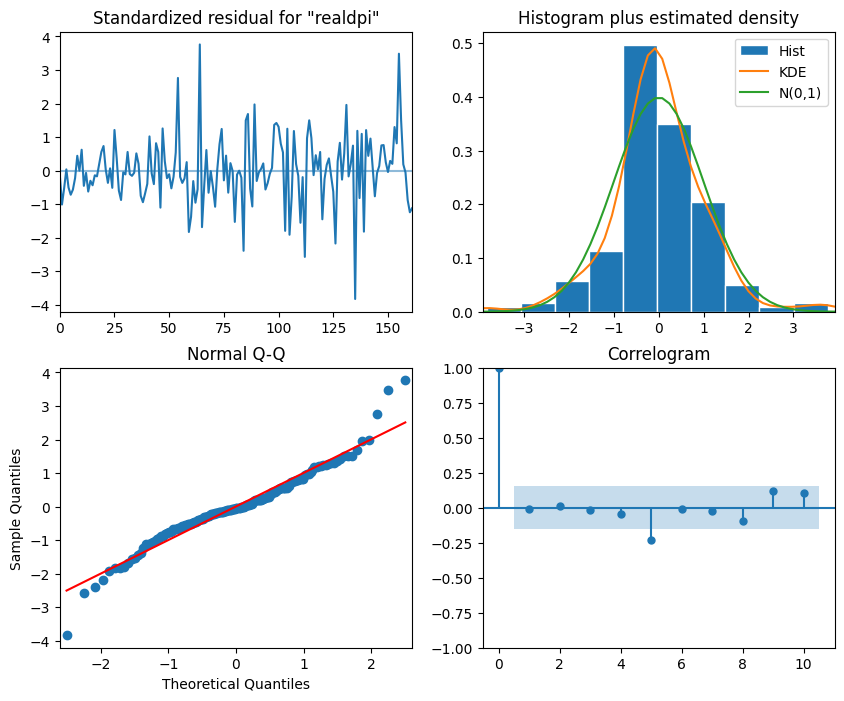

In [15]:
# Passing variable '0' fore Real Disposable Income
best_model_fit.plot_diagnostics(figsize=(10,8), variable=0);

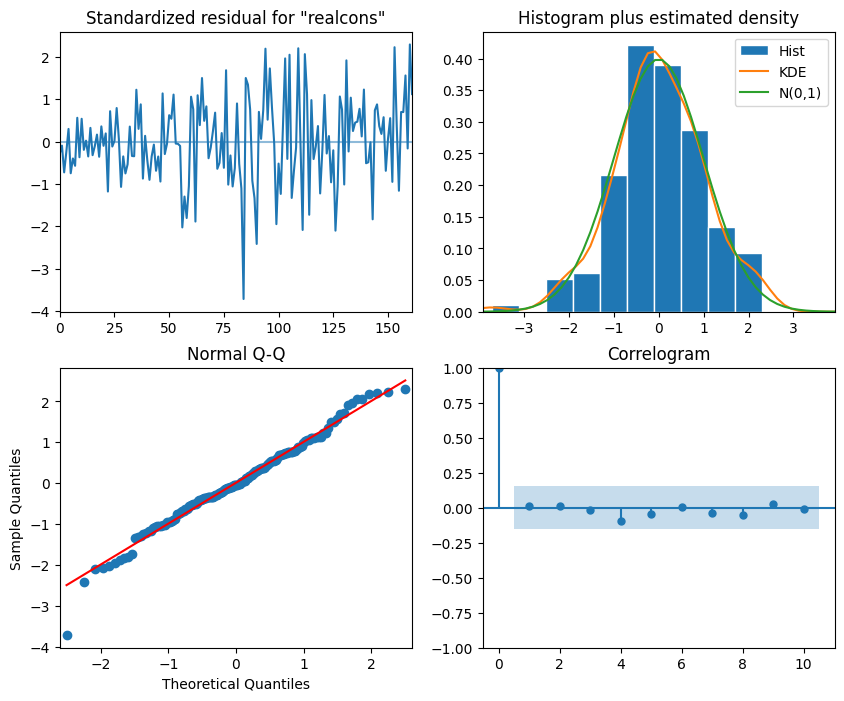

In [16]:
# Passing variable '1' for Real Consumption
best_model_fit.plot_diagnostics(figsize=(10,8), variable=1);

##### LJung-Box Test on: Real Consumption & Real Disposable Income

In [18]:
# Real Disposable Income

# Running the Ljung-Box test on the residuals
realgdp_residuals = best_model_fit.resid['realdpi']
results = acorr_ljungbox(realgdp_residuals, lags=np.arange(1, 11, 1))

# Accessing the p-values from the results dictionary
pvalues = results['lb_pvalue']

print(pvalues)

1     0.914071
2     0.985407
3     0.994571
4     0.984244
5     0.103514
6     0.164492
7     0.233844
8     0.212611
9     0.148736
10    0.121934
Name: lb_pvalue, dtype: float64


In [19]:
# Real Consumption

# Running the Ljung-Box test on the residuals
realcons_residuals = best_model_fit.resid['realcons']
results = acorr_ljungbox(realcons_residuals, lags=np.arange(1, 11, 1))

# Accessing the p-values from the results dictionary
pvalues = results['lb_pvalue']

print(pvalues)

1     0.877197
2     0.966224
3     0.995299
4     0.993577
5     0.995920
6     0.992410
7     0.994579
8     0.976051
9     0.982528
10    0.991684
Name: lb_pvalue, dtype: float64


##### Setting VAR(p) Rolling Forecast Function

In [21]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len
    
    if method == 'VAR':

        realdpi_pred_VAR = []
        realcons_pred_VAR = []
        
        for i in range(train_len, total_len, window):
            model = VARMAX(df[:i], order=(3,0))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            
            oos_pred_realdpi = predictions.predicted_mean.iloc[-window:]['realdpi']
            oos_pred_realcons = predictions.predicted_mean.iloc[-window:]['realcons']
            
            realdpi_pred_VAR.extend(oos_pred_realdpi)
            realcons_pred_VAR.extend(oos_pred_realcons)
        
        return realdpi_pred_VAR, realcons_pred_VAR
    
    elif method == 'last':
        realdpi_pred_last = []
        realcons_pred_last = []
        
        for i in range(train_len, total_len, window):
            
            realdpi_last = df[:i].iloc[-1]['realdpi']
            realcons_last = df[:i].iloc[-1]['realcons']
            
            realdpi_pred_last.extend(realdpi_last for _ in range(window))
            realcons_pred_last.extend(realcons_last for _ in range(window))
            
        return realdpi_pred_last, realcons_pred_last

#### Forecasting on 'realdpi' & 'realcons'

In [26]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 4

realdpi_pred_VAR, realcons_pred_VAR = rolling_forecast(endog_diff, TRAIN_LEN, HORIZON, WINDOW, 'VAR')

##### On Test

In [27]:
test = endog[163:]

test['realdpi_pred_VAR'] = pd.Series()
test['realdpi_pred_VAR'] = endog.iloc[162]['realdpi'] + np.cumsum(realdpi_pred_VAR)

test['realcons_pred_VAR'] = pd.Series()
test['realcons_pred_VAR'] = endog.iloc[162]['realcons'] + np.cumsum(realcons_pred_VAR)

test

,realdpi,realcons,realdpi_pred_VAR,realcons_pred_VAR
163,7887.7,7389.2,7829.222069,7354.322880
164,8053.4,7501.3,7897.184865,7430.251869
165,8135.9,7571.8,7960.558180,7496.624760
166,8222.3,7645.9,8014.750245,7556.608726
167,8234.6,7713.5,8080.695672,7630.997186
168,8296.5,7744.3,8142.385233,7692.848340
169,8273.7,7773.5,8200.115110,7753.871205
170,8484.5,7807.7,8259.354792,7812.543217
171,8385.5,7930.0,8264.378773,7864.643808
172,8611.6,7957.3,8320.851099,7895.068545


##### Adding Last Value

In [28]:
realdpi_pred_last, realcons_pred_last = rolling_forecast(endog, TRAIN_LEN, HORIZON, WINDOW, 'last')

test['realdpi_pred_last'] = realdpi_pred_last
test['realcons_pred_last'] = realcons_pred_last

test

,realdpi,realcons,realdpi_pred_VAR,realcons_pred_VAR,realdpi_pred_last,realcons_pred_last
163,7887.7,7389.2,7829.222069,7354.322880,7716.0,7199.9
164,8053.4,7501.3,7897.184865,7430.251869,7716.0,7199.9
165,8135.9,7571.8,7960.558180,7496.624760,7716.0,7199.9
166,8222.3,7645.9,8014.750245,7556.608726,7716.0,7199.9
167,8234.6,7713.5,8080.695672,7630.997186,8135.9,7571.8
168,8296.5,7744.3,8142.385233,7692.848340,8135.9,7571.8
169,8273.7,7773.5,8200.115110,7753.871205,8135.9,7571.8
170,8484.5,7807.7,8259.354792,7812.543217,8135.9,7571.8
171,8385.5,7930.0,8264.378773,7864.643808,8273.7,7773.5
172,8611.6,7957.3,8320.851099,7895.068545,8273.7,7773.5


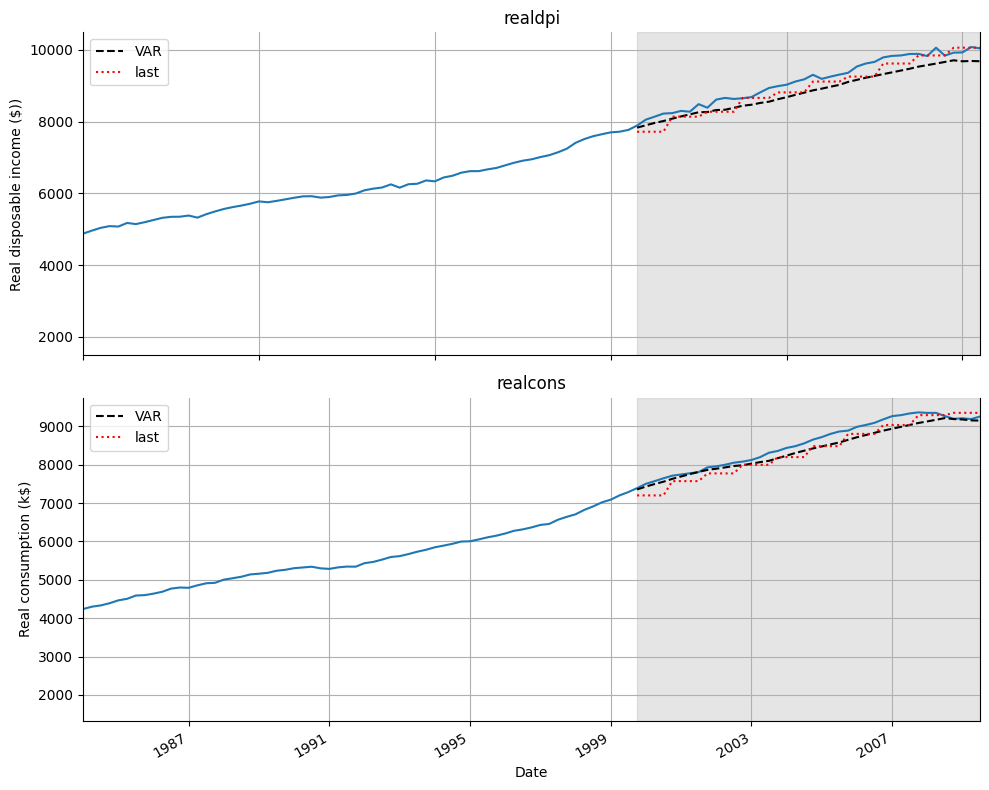

In [29]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,8))

ax1.plot(macro_econ_data['realdpi'])
ax1.plot(test['realdpi_pred_VAR'], 'k--', label='VAR')
ax1.plot(test['realdpi_pred_last'], 'r:', label='last')
ax1.set_xlabel('Date')
ax1.set_ylabel('Real disposable income ($))')
ax1.set_title('realdpi')
ax1.spines['top'].set_alpha(0)
ax1.axvspan(163, 202, color='#808080', alpha=0.2)
ax1.set_xlim(100, 202)
ax1.legend(loc=2)
ax1.grid(True)

ax2.plot(macro_econ_data['realcons'])
ax2.plot(test['realcons_pred_VAR'], 'k--', label='VAR')
ax2.plot(test['realcons_pred_last'], 'r:', label='last')
ax2.set_xlabel('Date')
ax2.set_ylabel('Real consumption (k$)')
ax2.set_title('realcons')
ax2.spines['top'].set_alpha(0)
ax2.axvspan(163, 202, color='#808080', alpha=0.2)
ax2.set_xlim(100, 202)
ax2.legend(loc=2)
ax2.grid(True)

plt.xticks(np.arange(0, 208, 16), np.arange(1959, 2010, 4))
plt.xlim(100, 202)

fig.autofmt_xdate()
plt.tight_layout()

#### Mean Absolute Percentage Error Function

In [30]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [31]:
mape_realdpi_VAR = mape(test['realdpi'], test['realdpi_pred_VAR'])
mape_realdpi_last = mape(test['realdpi'], test['realdpi_pred_last'])

mape_realcons_VAR = mape(test['realcons'], test['realcons_pred_VAR'])
mape_realcons_last = mape(test['realcons'], test['realcons_pred_last'])

#### Mape Model Outcomes

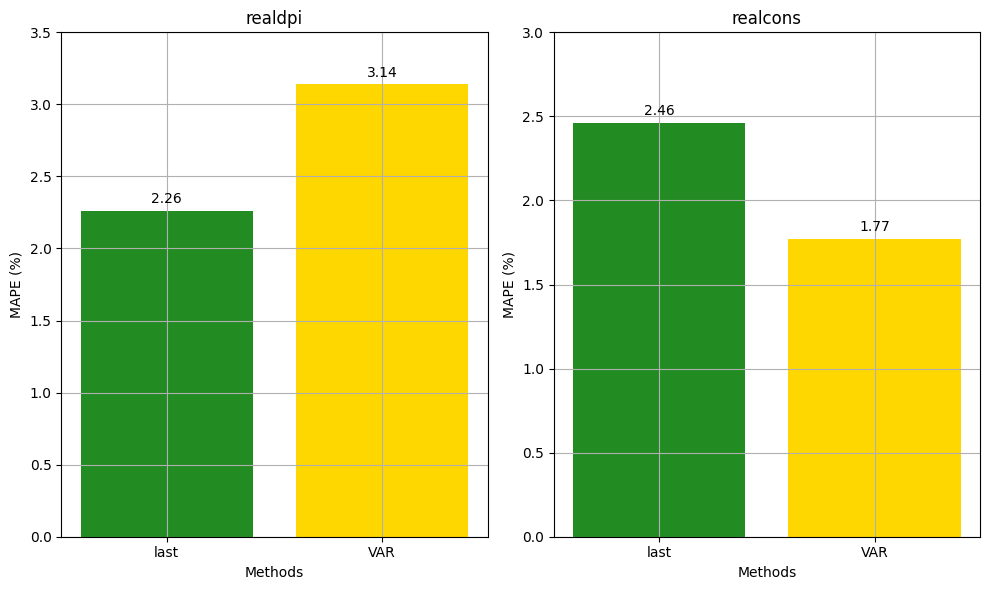

In [33]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,6))

x = ['last', 'VAR']
y1 = [mape_realdpi_last, mape_realdpi_VAR]
y2 = [mape_realcons_last, mape_realcons_VAR]

ax1.bar(x, y1, color=['forestgreen', 'gold'])
ax1.set_xlabel('Methods')
ax1.set_ylabel('MAPE (%)')
ax1.set_title('realdpi')
ax1.set_ylim(0, 3.5)
ax1.grid(True)

ax2.bar(x,y2, color=['forestgreen', 'gold'])
ax2.set_xlabel('Methods')
ax2.set_ylabel('MAPE (%)')
ax2.set_title('realcons')
ax2.set_ylim(0, 3)
ax2.grid(True)

for index, value in enumerate(y1):
    ax1.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')
    
for index, value in enumerate(y2):
    ax2.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')

plt.tight_layout()